In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from textblob import TextBlob
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

Load and Prepare Data

In [2]:
data = pd.read_csv('Problem_C_Data/pacifier.tsv', sep='\t')

data['review_body'] = data['review_body'].fillna('').astype(str).str.lower()

data['sentiment'] = data['review_body'].apply(lambda x: TextBlob(x).sentiment.polarity)


Text Vectorization

In [3]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf.fit_transform(data['review_body']).toarray()


Feature Engineering and Dataset Splitting

In [4]:
X = pd.concat([pd.DataFrame(tfidf_features), data[['sentiment', 'helpful_votes', 'total_votes']]], axis=1)
y = data['star_rating'].apply(lambda x: 1 if x > 3 else 0)  # Binary classification for simplicity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


Build and Train the Neural Network

In [58]:
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)

class_weight_dict = {}

for cls, weight in zip(unique_classes, class_weights):
    class_weight_dict[cls] = weight  


model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dropout(0.3)) 
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Dropout(0.3))  
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))


optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict, validation_split=0.25)


C:\Users\16057\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10
333/333 [==============================] - 4s 10ms/step - loss: 1.3938 - accuracy: 0.7794 - val_loss: 0.5542 - val_accuracy: 0.7964
Epoch 2/10
333/333 [==============================] - 4s 12ms/step - loss: 0.4571 - accuracy: 0.8412 - val_loss: 0.5546 - val_accuracy: 0.8015
Epoch 3/10
333/333 [==============================] - 4s 11ms/step - loss: 0.4009 - accuracy: 0.8564 - val_loss: 0.3709 - val_accuracy: 0.8702
Epoch 4/10
333/333 [==============================] - 4s 11ms/step - loss: 0.3816 - accuracy: 0.8735 - val_loss: 0.5027 - val_accuracy: 0.8130
Epoch 5/10
333/333 [==============================] - 4s 12ms/step - loss: 0.3557 - accuracy: 0.8829 - val_loss: 0.3994 - val_accuracy: 0.8648
Epoch 6/10
333/333 [==============================] - 4s 11ms/step - loss: 0.3177 - accuracy: 0.9093 - val_loss: 0.4769 - val_accuracy: 0.8412
Epoch 7/10
333/333 [==============================] - 4s 11ms/step - loss: 0.3020 - accuracy: 0.9205 - val_loss: 0.4088 - val_accuracy: 0.8741

Model Evaluation

In [59]:
y_pred_nn = (model.predict(X_test) > 0.5).astype(int)

# Evaluating the model
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


148/148 [==============================] - 0s 3ms/step
Neural Network Accuracy: 0.8770855332629356
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       881
           1       0.94      0.91      0.92      3854

    accuracy                           0.88      4735
   macro avg       0.79      0.83      0.81      4735
weighted avg       0.89      0.88      0.88      4735



Confusion matrix

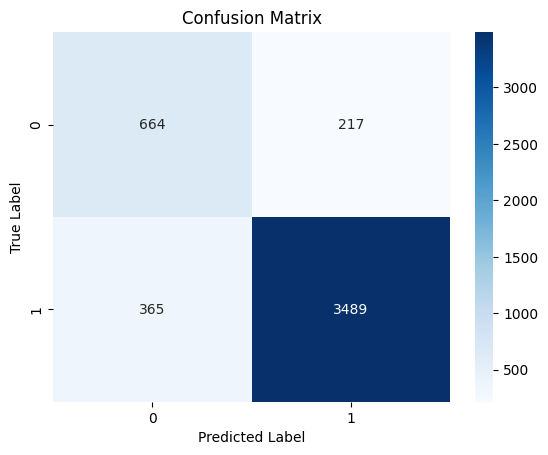

In [60]:
cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()